**If you are using Colab. Please run the code under this text.**

In [ ]:
# Install all third-party libraries needed for this notebook.
# This is designed for a fresh Google Colab runtime.

!pip install torch torchvision torchaudio datasets sacrebleu rouge-score tqdm numpy pandas matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.1 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=75dcb4a612c606c4815b2ede61ced341ab6e262c1fb950754536cf4934475768
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [ ]:
# Core library imports for numerical computing, neural networks, and evaluation.
# Also set the compute device (GPU/CPU) and fix random seeds for reproducibility.

import math, random, os, time, re
from dataclasses import dataclass
from typing import List, Tuple, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset, DatasetDict
import sacrebleu
from rouge_score import rouge_scorer

import os
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

print("Device:", DEVICE)


Device: cuda


## 1) Data: Multi30k (EN–DE)

- Use huggingface datasets
- Simple word-level tokenization for clarity (you can switch to subwords later)
- Special tokens: `<pad>`, `<bos>`, `<eos>`, `<unk>`


In [ ]:
# Load a parallel English–German translation dataset (Multi30k or IWSLT14 fallback).
# - Normalize the raw text (lowercasing, basic cleaning).
# - Tokenize source/target sentences.
# - Build vocabularies with frequency thresholds and special tokens.
# - Wrap examples in a custom Dataset and create DataLoaders with padding-aware collate_fn.

# -------- 1) Load dataset (robust) --------
try:
    ds = load_dataset("bentrevett/multi30k")   # columns: 'en', 'de'; splits: train/validation/test
    SRC_LANG, TGT_LANG = "en", "de"
    print("Loaded bentrevett/multi30k")
except Exception as e1:
    print("bentrevett/multi30k failed:", e1)
    # Fallback to an IWSLT14 mirror with 'translation' dicts
    ds = load_dataset("bbaaaa/iwslt14-de-en")
    def _to_pairs(batch):
        en, de = [], []
        for tr in batch["translation"]:
            en.append(tr["en"])
            de.append(tr["de"])
        return {"en": en, "de": de}
    ds = ds.map(_to_pairs, batched=True, remove_columns=ds["train"].column_names)
    # Normalize split names if needed
    if "validation" not in ds:
        if "valid" in ds:
            ds = DatasetDict({
                "train": ds["train"],
                "validation": ds["valid"],
                "test": ds["test"] if "test" in ds else ds["valid"],
            })
        else:
            # last resort: carve a small validation from train
            split = ds["train"].train_test_split(test_size=0.05, seed=42)
            ds = DatasetDict({"train": split["train"], "validation": split["test"], "test": ds.get("test", split["test"])})
    SRC_LANG, TGT_LANG = "en", "de"
    print("Loaded bbaaaa/iwslt14-de-en (mapped to en/de)")

train_ds, valid_ds, test_ds = ds["train"], ds["validation"], ds["test"]

# -------- 2) Tokenizer & vocab (same as yours) --------
_token_pattern = re.compile(r"\w+|[^\w\s]", re.UNICODE)
def tokenize(text: str) -> List[str]:
    text = text.strip().lower()
    return _token_pattern.findall(text)

PAD, BOS, EOS, UNK = "<pad>", "<bos>", "<eos>", "<unk>"

def build_vocab(examples, lang: str, min_freq: int = 2, max_size: int = 30000):
    from collections import Counter
    counter = Counter()
    for ex in examples:
        toks = tokenize(ex[lang])
        counter.update(toks)
    items = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
    words = [w for w, c in items if c >= min_freq][:max_size-4]
    stoi = {PAD:0, BOS:1, EOS:2, UNK:3}
    for w in words:
        if w not in stoi:
            stoi[w] = len(stoi)
    itos = {i:w for w,i in stoi.items()}
    return stoi, itos

src_stoi, src_itos = build_vocab(train_ds, SRC_LANG)
tgt_stoi, tgt_itos = build_vocab(train_ds, TGT_LANG)

VOCAB_SRC, VOCAB_TGT = len(src_stoi), len(tgt_stoi)
print("Vocab sizes:", VOCAB_SRC, VOCAB_TGT)

def numericalize(text: str, stoi: Dict[str,int], add_bos_eos: bool, max_len: int = 100) -> List[int]:
    toks = tokenize(text)
    if add_bos_eos:
        toks = [BOS] + toks + [EOS]
    ids = [stoi.get(t, stoi[UNK]) for t in toks][:max_len]
    return ids

class MTDataset(Dataset):
    def __init__(self, split):
        self.data = split
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        ex = self.data[idx]
        src_ids = numericalize(ex[SRC_LANG], src_stoi, add_bos_eos=True)
        tgt_ids = numericalize(ex[TGT_LANG], tgt_stoi, add_bos_eos=True)
        return torch.tensor(src_ids, dtype=torch.long), torch.tensor(tgt_ids, dtype=torch.long)

def collate_batch(batch):
    src_seqs, tgt_seqs = zip(*batch)
    src_pad = pad_sequence(src_seqs, batch_first=True, padding_value=src_stoi[PAD])
    tgt_pad = pad_sequence(tgt_seqs, batch_first=True, padding_value=tgt_stoi[PAD])
    src_len = torch.tensor([len(x) for x in src_seqs], dtype=torch.long)
    tgt_len = torch.tensor([len(x) for x in tgt_seqs], dtype=torch.long)
    return src_pad, src_len, tgt_pad, tgt_len

BATCH_SIZE = 64
train_loader = DataLoader(MTDataset(train_ds), batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_batch)
valid_loader = DataLoader(MTDataset(valid_ds), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(MTDataset(test_ds),  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

src_pad_id = src_stoi[PAD]
tgt_pad_id = tgt_stoi[PAD]

README.md: 0.00B [00:00, ?B/s]

train.jsonl: 0.00B [00:00, ?B/s]

val.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Loaded bentrevett/multi30k
Vocab sizes: 5898 7882


## 2) Encoder–Decoder + Pluggable Attention

- Encoder: **Bi-GRU**
- Decoder: **GRU** with context vector
- Attention:
  - **Bahdanau (Additive)**
  - **Luong (General Multiplicative)**
  - **Scaled Dot-Product**


In [ ]:
# Define the sequence-to-sequence architecture with attention.
# Components:
#   - ModelConfig dataclass: centralizes hyperparameters (dims, dropout, attention type).
#   - Encoder: bidirectional GRU over source tokens.
#   - Attention mechanisms: Bahdanau, Luong, and scaled dot-product variants.
#   - Decoder: GRU that consumes previous token + context vector and predicts next token.
#   - Seq2Seq wrapper: handles encoding, teacher-forced decoding, and masks.
#   - Training utilities: token-level cross-entropy loss, gradient clipping, and epoch loop.

from dataclasses import dataclass

@dataclass
class ModelConfig:
    emb_dim: int = 256
    enc_hidden: int = 256
    dec_hidden: int = 256
    dropout: float = 0.2
    attn_type: str = "bahdanau"  # "bahdanau" | "luong" | "scaled_dot"

class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden, dropout=0.2):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.rnn = nn.GRU(emb_dim, hidden, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden*2, hidden)  # to init decoder state
    def forward(self, src, src_len):
        # src: B x Ts
        x = self.dropout(self.emb(src))        # B x Ts x E
        outputs, h = self.rnn(x)               # outputs: B x Ts x (2H), h: 2 x B x H
        h_cat = torch.cat([h[-2], h[-1]], dim=1)  # B x 2H
        h0 = torch.tanh(self.fc(h_cat))           # B x H
        return outputs, h0

class BahdanauAttention(nn.Module):
    def __init__(self, enc_dim, dec_dim):
        super().__init__()
        self.W_h = nn.Linear(enc_dim, dec_dim, bias=False)
        self.W_s = nn.Linear(dec_dim, dec_dim, bias=False)
        self.v   = nn.Linear(dec_dim, 1, bias=False)
    def forward(self, enc_out, dec_state, mask):
        # enc_out: B x Ts x E ; dec_state: B x H ; mask: B x Ts (True=valid)
        Wh = self.W_h(enc_out)                      # B x Ts x H
        Ws = self.W_s(dec_state).unsqueeze(1)       # B x 1 x H
        e = self.v(torch.tanh(Wh + Ws)).squeeze(-1) # B x Ts
        e = e.masked_fill(~mask, -1e9)
        a = torch.softmax(e, dim=-1)                # B x Ts
        ctx = torch.bmm(a.unsqueeze(1), enc_out).squeeze(1)  # B x E
        return ctx, a

class LuongAttention(nn.Module):
    def __init__(self, enc_dim, dec_dim):
        super().__init__()
        self.W = nn.Linear(enc_dim, dec_dim, bias=False)
    def forward(self, enc_out, dec_state, mask):
        Wh = self.W(enc_out)                    # B x Ts x H
        s  = dec_state.unsqueeze(-1)            # B x H x 1
        e  = torch.bmm(Wh, s).squeeze(-1)       # B x Ts
        e = e.masked_fill(~mask, -1e9)
        a  = torch.softmax(e, dim=-1)
        ctx = torch.bmm(a.unsqueeze(1), enc_out).squeeze(1)
        return ctx, a

class ScaledDotProductAttention(nn.Module):
    def __init__(self, enc_dim, dec_dim):
        super().__init__()
        self.Q = nn.Linear(dec_dim, dec_dim, bias=False)
        self.K = nn.Linear(enc_dim, dec_dim, bias=False)
        self.V = nn.Linear(enc_dim, enc_dim, bias=False)
        self.scale = math.sqrt(dec_dim)
    def forward(self, enc_out, dec_state, mask):
        q = self.Q(dec_state).unsqueeze(1)         # B x 1 x H
        k = self.K(enc_out)                        # B x Ts x H
        v = self.V(enc_out)                        # B x Ts x E
        e = torch.bmm(q, k.transpose(1,2)).squeeze(1) / self.scale  # B x Ts
        e = e.masked_fill(~mask, -1e9)
        a = torch.softmax(e, dim=-1)               # B x Ts
        ctx = torch.bmm(a.unsqueeze(1), v).squeeze(1)               # B x E
        return ctx, a

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, enc_hidden, dec_hidden, attn_type="bahdanau", dropout=0.2):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.rnn = nn.GRU(emb_dim + enc_hidden*2, dec_hidden, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(dec_hidden + enc_hidden*2, vocab_size)
        enc_dim = enc_hidden*2
        if attn_type == "bahdanau":
            self.attn = BahdanauAttention(enc_dim, dec_hidden)
        elif attn_type == "luong":
            self.attn = LuongAttention(enc_dim, dec_hidden)
        elif attn_type == "scaled_dot":
            self.attn = ScaledDotProductAttention(enc_dim, dec_hidden)
        else:
            raise ValueError("Unknown attn_type")
        self.attn_type = attn_type

    def forward_step(self, y_prev, h, enc_out, mask):
        # y_prev: B (previous token ids)
        # h:      1 x B x H (decoder hidden)
        # enc_out: B x Ts x (2H)
        emb = self.dropout(self.emb(y_prev).unsqueeze(1))  # B x 1 x E
        dec_state = h[-1]                                  # B x H
        ctx, attn = self.attn(enc_out, dec_state, mask)    # B x 2H, B x Ts
        x = torch.cat([emb, ctx.unsqueeze(1)], dim=-1)     # B x 1 x (E+2H)
        out, h_new = self.rnn(x, h)                        # out: B x 1 x H
        out = out.squeeze(1)                               # B x H
        logits = self.fc_out(torch.cat([out, ctx], dim=-1))# B x V
        return logits, h_new, attn, ctx

    def forward(self, tgt, h0, enc_out, src_mask, teacher_forcing=0.5):
        # Teacher-forced decoding for training.
        # tgt: B x Tt (with BOS ... EOS)
        B, Tt = tgt.size()
        h = h0.unsqueeze(0)
        logits_list = []
        attn_list = []
        y_prev = tgt[:, 0]  # assume first token is BOS

        for t in range(1, Tt):
            logits, h, attn, _ = self.forward_step(y_prev, h, enc_out, src_mask)
            logits_list.append(logits.unsqueeze(1))
            attn_list.append(attn.unsqueeze(1))
            # next input
            if random.random() < teacher_forcing:
                y_prev = tgt[:, t]
            else:
                y_prev = logits.argmax(dim=-1)
        if logits_list:
            logits_all = torch.cat(logits_list, dim=1)  # B x (Tt-1) x V
            attns = torch.cat(attn_list, dim=1)         # B x (Tt-1) x Ts
        else:
            V = self.fc_out.out_features
            logits_all = torch.zeros(B, 0, V, device=enc_out.device)
            attns = torch.zeros(B, 0, enc_out.size(1), device=enc_out.device)
        return logits_all, attns

class Seq2Seq(nn.Module):
    def __init__(self, cfg: ModelConfig, vocab_src, vocab_tgt):
        super().__init__()
        self.enc = Encoder(vocab_src, cfg.emb_dim, cfg.enc_hidden, cfg.dropout)
        self.dec = Decoder(vocab_tgt, cfg.emb_dim, cfg.enc_hidden, cfg.dec_hidden, cfg.attn_type, cfg.dropout)
        self.cfg = cfg

    def make_src_mask(self, src):
        # mask True for valid tokens (not PAD)
        return (src != 0)

    def forward(self, src, src_len, tgt, teacher_forcing=0.5):
        enc_out, h0 = self.enc(src, src_len)
        mask = self.make_src_mask(src)
        logits, attns = self.dec(tgt, h0, enc_out, mask, teacher_forcing=teacher_forcing)
        return logits, attns

def _compute_batch_loss(model, src, src_len, tgt, teacher_forcing):
    logits, _ = model(src, src_len, tgt, teacher_forcing=teacher_forcing)
    target = tgt[:, 1:]
    loss = F.cross_entropy(
        logits.reshape(-1, logits.size(-1)),
        target.reshape(-1),
        ignore_index=tgt_pad_id,
        reduction="sum",
    )
    token_count = (target != tgt_pad_id).sum().item()
    return loss, token_count

def evaluate_loss(model, loader, teacher_forcing=1.0):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    with torch.no_grad():
        for src, src_len, tgt, tgt_len in loader:
            src = src.to(DEVICE)
            src_len = src_len.to(DEVICE)
            tgt = tgt.to(DEVICE)
            batch_loss, tokens = _compute_batch_loss(model, src, src_len, tgt, teacher_forcing)
            total_loss += batch_loss.item()
            total_tokens += tokens
    return total_loss / max(total_tokens, 1)

def train_model(attn_type="bahdanau", epochs=5, lr=1e-3, teacher_forcing=0.5, clip=1.0,
                eval_every=1, max_eval_batches=5, decode_kwargs=None, verbose=True):
    cfg = ModelConfig(attn_type=attn_type)
    model = Seq2Seq(cfg, VOCAB_SRC, VOCAB_TGT).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = []
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        total_tokens = 0
        start_time = time.time()
        for src, src_len, tgt, tgt_len in train_loader:
            src = src.to(DEVICE)
            src_len = src_len.to(DEVICE)
            tgt = tgt.to(DEVICE)
            optimizer.zero_grad()
            raw_loss, tokens = _compute_batch_loss(model, src, src_len, tgt, teacher_forcing)
            norm = max(tokens, 1)
            loss = raw_loss / norm
            loss.backward()
            if clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            total_loss += raw_loss.item()
            total_tokens += tokens
        avg_loss = total_loss / max(total_tokens, 1)
        metrics = {
            "epoch": epoch,
            "train_loss": avg_loss,
            "train_ppl": math.exp(avg_loss) if avg_loss < 30 else float("inf"),
            "elapsed_sec": time.time() - start_time,
        }
        if eval_every and (epoch % eval_every == 0):
            val_loss = evaluate_loss(model, valid_loader, teacher_forcing=1.0)
            metrics["valid_loss"] = val_loss
            metrics["valid_ppl"] = math.exp(val_loss) if val_loss < 30 else float("inf")
            decode_dict = decode_kwargs or {}
            bleu, rougeL, _, _ = evaluate_bleu_rouge(model, valid_loader, max_batches=max_eval_batches, decode_kwargs=decode_dict)
            metrics["bleu"] = bleu
            metrics["rougeL"] = rougeL
        history.append(metrics)
        if verbose:
            msg = f"Epoch {epoch}/{epochs} - train_loss {avg_loss:.3f}"
            if "valid_loss" in metrics:
                msg += f" | valid_loss {metrics['valid_loss']:.3f} | BLEU {metrics['bleu']:.1f} | ROUGE-L {metrics['rougeL']:.1f}"
            print(msg)
    return model, history


## 3) Training & Metrics

- Loss: token-level cross-entropy (ignore PAD)
- Perplexity: `exp(avg NLL)`
- BLEU: sacreBLEU (validation quick pass each epoch)
- ROUGE-L: rouge-score


In [ ]:
# Evaluation utilities for translation quality and decoding.
#   - evaluate_bleu_rouge: runs the model on a dataset, decodes hypotheses,
#     and computes sacreBLEU + ROUGE-L scores with light detokenization.
#   - beam_search_decode: implements batched beam search, returning the best
#     hypothesis per example along with the full attention history.


import torch
import torch.nn.functional as F

def evaluate_bleu_rouge(model, loader, max_len=60, max_batches=None, detok=True, decode_kwargs=None):
    """
    Evaluate BLEU (sacreBLEU) and ROUGE-L with optional detokenization to avoid warnings.
    If detok=True (recommended), we lightly detokenize predictions/refs before scoring.
    If detok=False, we compute BLEU with tokenize='none' and force=True.
    """
    model.eval()
    pred_texts, ref_texts = [], []
    import numpy as _np
    import sacrebleu as _sacrebleu
    from rouge_score import rouge_scorer as _rouge_scorer
    with torch.no_grad():
        for b_idx, (src, src_len, tgt, tgt_len) in enumerate(loader):
            src = src.to(DEVICE); src_len = src_len.to(DEVICE)
            hyps, _ = beam_search_decode(model, src, src_len, max_len=max_len)
            # ---------------------------

            for i in range(len(hyps)):
                pred = ids_to_text(hyps[i], tgt_itos)
                ref  = ids_to_text(tgt[i].cpu().tolist()[1:], tgt_itos)
                pred_texts.append(pred)
                ref_texts.append(ref)
            if max_batches is not None and (b_idx+1) >= max_batches:
                break

    if detok:
        import re as _re
        _rules = [
            (r"\s+([?.!,;:%])", r"\1"),
            (r"([(\[{])\s+", r"\1"),
            (r"\s+([)\]}])", r"\1"),
            (r"\s+'", r"'"),
            (r"'\s+", r"'"),
            (r"\s+-\s+", r"-"),
        ]
        def _detok(s: str) -> str:
            for pat, rep in _rules:
                s = _re.sub(pat, rep, s)
            s = _re.sub(r"\s{2,}", " ", s)
            return s.strip()
        pred_eval = [_detok(x) for x in pred_texts]
        ref_eval  = [_detok(x) for x in ref_texts]
        bleu = _sacrebleu.corpus_bleu(pred_eval, [ref_eval]).score
        scorer = _rouge_scorer.RougeScorer(["rougeL"], use_stemmer=False)
        rougeLs = [scorer.score(r, p)["rougeL"].fmeasure for p, r in zip(ref_eval, pred_eval)]
    else:
        bleu = _sacrebleu.corpus_bleu(pred_texts, [ref_texts], tokenize="none", force=True).score
        scorer = _rouge_scorer.RougeScorer(["rougeL"], use_stemmer=False)
        rougeLs = [scorer.score(r, p)["rougeL"].fmeasure for p, r in zip(ref_texts, pred_texts)]

    rougeL = 100.0 * float(_np.mean(rougeLs))
    return bleu, rougeL, pred_texts, ref_texts

@torch.no_grad()
def beam_search_decode(model, src, src_len, max_len=60, beam_size=5, alpha=0.7):
    """
    Beam search with length penalty (Google NMT).
    Returns:
        hyps: list of best token id sequences (B elements, BOS removed, EOS possibly present)
        attn_map: Tensor (B, Tgen_max, Ts) attention per generated step
    """
    model.eval()
    enc_out, h0 = model.enc(src, src_len)
    mask = model.make_src_mask(src)
    B, Ts = src.size(0), src.size(1)
    device = src.device

    bos_id = tgt_stoi[BOS]
    eos_id = tgt_stoi[EOS]

    all_hyps, all_As = [], []

    for b in range(B):
        enc_b  = enc_out[b:b+1]
        mask_b = mask[b:b+1]
        h_b    = h0[b:b+1].unsqueeze(0)     # 1 x 1 x H

        # beams: list of tuples (logp, tokens, h, attn_steps)
        beams = [(0.0, [bos_id], h_b, [])]
        finished = []  # (logp, tokens, attn_steps)

        for _ in range(max_len):
            candidates = []
            for logp, toks, h, attns in beams:
                last = toks[-1]
                if last == eos_id:
                    finished.append((logp, toks, attns))
                    continue

                logits, h_new, attn, _ = model.dec.forward_step(
                    torch.tensor([last], device=device), h, enc_b, mask_b
                )

                log_probs = F.log_softmax(logits, dim=-1).squeeze(0)   # V
                topk_logp, topk_idx = torch.topk(log_probs, beam_size)

                for k in range(beam_size):
                    tok = int(topk_idx[k].item())
                    new_logp = logp + float(topk_logp[k].item())
                    candidates.append(
                        (new_logp, toks + [tok], h_new, attns + [attn.squeeze(0)])
                    )

            if not candidates:
                break

            candidates.sort(key=lambda x: x[0], reverse=True)
            beams = candidates[:beam_size]

            if all(t[-1] == eos_id for _, t, _, _ in beams):
                finished.extend([(lp, t, a) for lp, t, _, a in beams])
                break

        def lp(L, a=alpha): return ((5 + L) ** a) / ((5 + 1) ** a)

        if not finished:
            finished = [(lp_, t, a) for lp_, t, _, a in beams]

        # length for penalty excludes BOS
        def eff_len(seq):
            return max(1, len([z for z in seq if z != bos_id]))
        finished.sort(key=lambda x: x[0] / lp(eff_len(x[1]), alpha), reverse=True)
        best_logp, best_toks, best_attns = finished[0]

        A = torch.stack(best_attns, dim=0) if len(best_attns) > 0 else torch.zeros(0, Ts, device=device)
        out_toks = [t for t in best_toks if t != bos_id]
        all_hyps.append(out_toks)
        all_As.append(A)

    Tgen_max = max((A.size(0) for A in all_As), default=0)
    attn_batch = torch.zeros(B, Tgen_max, Ts, device=device)
    for i, A in enumerate(all_As):
        attn_batch[i, :A.size(0), :A.size(1)] = A

    return all_hyps, attn_batch


## 4) Attention Heatmaps

Plot alignment for 5+ validation samples.


In [ ]:
# Utility functions for qualitative analysis.
#   - ids_to_text: map integer token IDs back to readable tokens, stripping BOS/EOS/PAD.
#   - plot_attention_heatmap: visualize attention weights as a heatmap showing
#     alignment between source tokens (x-axis) and generated target tokens (y-axis).

def ids_to_text(ids, itos):
    toks = []
    for i in ids:
        tok = itos.get(i, UNK)
        if tok == EOS: break
        if tok in (BOS, PAD): continue
        toks.append(tok)
    return " ".join(toks)

def plot_attention_heatmap(attn_map, src_ids, hyp_ids, idx=0):
    # Kaynak (Source) tokenları al
    src_tokens = []
    for i in src_ids[idx].tolist():
        tok = src_itos.get(int(i), UNK)
        if tok == PAD: break
        src_tokens.append(tok)

    pred_tokens = []
    for i in hyp_ids[idx]:
        tok = tgt_itos.get(i, UNK)
        if tok == EOS:
            pred_tokens.append(EOS)
            break
        if tok in (BOS, PAD): continue
        pred_tokens.append(tok)

    A = attn_map[idx].cpu().numpy()
    A = A[:len(pred_tokens), :len(src_tokens)]

    plt.figure(figsize=(min(12, 0.6*len(src_tokens)), min(10, 0.4*len(pred_tokens))))
    plt.imshow(A, aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(src_tokens)), src_tokens, rotation=90)
    plt.yticks(range(len(pred_tokens)), pred_tokens)
    plt.xlabel("Source tokens")
    plt.ylabel("Predicted tokens (Decoding steps)")
    plt.title("Attention alignment")
    plt.tight_layout()
    plt.show()

The best epoch i've found is 8. If you want to change it you can change the target_epoch and see the results.

In [ ]:
# Train three separate models under the same training regime,
# each differing only in the attention mechanism:
#   1) Bahdanau (additive) attention
#   2) Luong (multiplicative) attention
#   3) Scaled dot-product attention
# After training, save each model's parameters to disk for later analysis.

target_epoch = 8
print(f"--- Bahdanau model training with {target_epoch} epoch \n")
model_bahdanau, hist_b = train_model(attn_type="bahdanau", epochs=target_epoch)
torch.save(model_bahdanau.state_dict(), "bahdanau.pt")
print(">>> Bahdanau model is done \n")

print(f"--- Luong model training with {target_epoch} epoch \n")
model_luong, hist_l = train_model(attn_type="luong", epochs=target_epoch)
torch.save(model_luong.state_dict(), "luong.pt")
print(">>> Luong model is done \n")

print(f"--- Scaled-Dot model training with {target_epoch} epoch \n")
model_scaled, hist_s = train_model(attn_type="scaled_dot", epochs=target_epoch)
torch.save(model_scaled.state_dict(), "scaled_dot.pt")
print(">>> Scaled-Dot model is done \n")

print(" Every model is saved.")

--- Bahdanau model training with 8 epoch 

Epoch 1/8 - train_loss 3.912 | valid_loss 2.507 | BLEU 26.8 | ROUGE-L 57.0
Epoch 2/8 - train_loss 2.654 | valid_loss 2.082 | BLEU 31.4 | ROUGE-L 61.2
Epoch 3/8 - train_loss 2.214 | valid_loss 1.911 | BLEU 33.2 | ROUGE-L 63.0
Epoch 4/8 - train_loss 1.913 | valid_loss 1.832 | BLEU 34.5 | ROUGE-L 63.4
Epoch 5/8 - train_loss 1.715 | valid_loss 1.812 | BLEU 35.7 | ROUGE-L 64.2
Epoch 6/8 - train_loss 1.586 | valid_loss 1.824 | BLEU 34.1 | ROUGE-L 63.6
Epoch 7/8 - train_loss 1.479 | valid_loss 1.806 | BLEU 34.4 | ROUGE-L 63.7
Epoch 8/8 - train_loss 1.391 | valid_loss 1.790 | BLEU 35.1 | ROUGE-L 64.4
>>> Bahdanau model is done 

--- Luong model training with 8 epoch 

Epoch 1/8 - train_loss 4.263 | valid_loss 3.024 | BLEU 17.9 | ROUGE-L 49.7
Epoch 2/8 - train_loss 3.166 | valid_loss 2.519 | BLEU 23.2 | ROUGE-L 55.3
Epoch 3/8 - train_loss 2.739 | valid_loss 2.352 | BLEU 25.3 | ROUGE-L 56.9
Epoch 4/8 - train_loss 2.455 | valid_loss 2.231 | BLEU 27.5 | R

Please change the model that you want to plot. The code is under this text.


In [ ]:
plotting_model = model_scaled # model_bahdanau, model_luong, or model_scaled

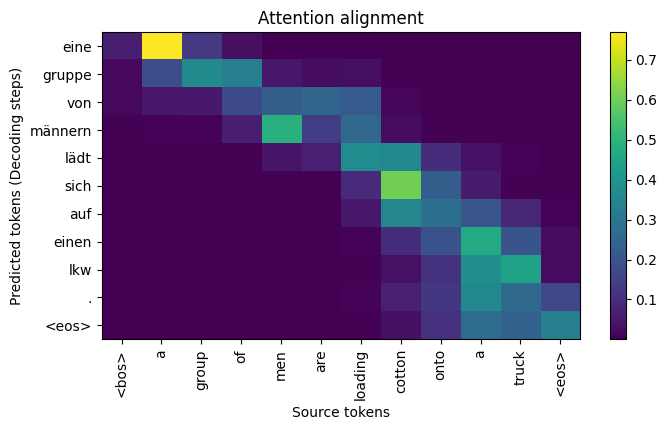

SRC : a group of men are loading cotton onto a truck
PRED: eine gruppe von männern lädt sich auf einen lkw .
REF : eine gruppe von männern lädt <unk> auf einen lastwagen


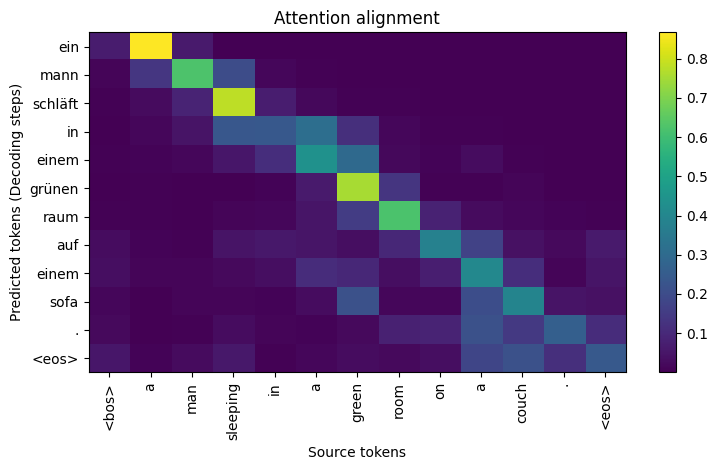

SRC : a man sleeping in a green room on a couch .
PRED: ein mann schläft in einem grünen raum auf einem sofa .
REF : ein mann schläft in einem grünen raum auf einem sofa .


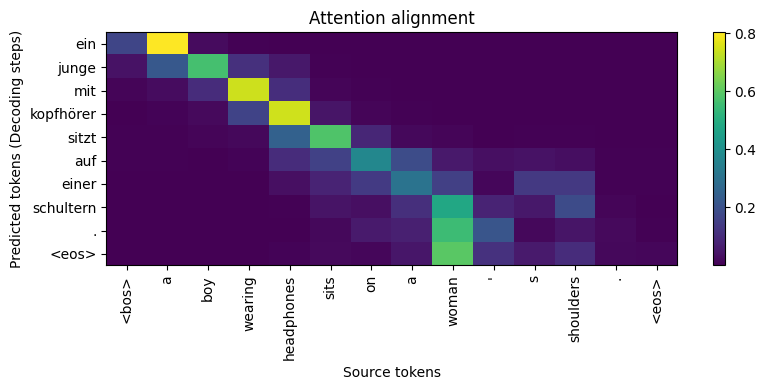

SRC : a boy wearing headphones sits on a woman ' s shoulders .
PRED: ein junge mit kopfhörer sitzt auf einer schultern .
REF : ein junge mit kopfhörern sitzt auf den schultern einer frau .


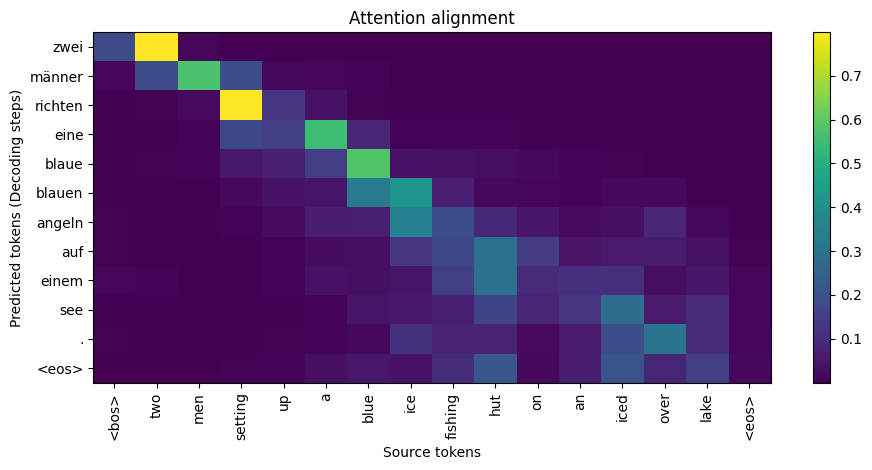

SRC : two men setting up a blue ice fishing hut on an iced over lake
PRED: zwei männer richten eine blaue blauen angeln auf einem see .
REF : zwei männer bauen eine blaue <unk> auf einem <unk> see auf


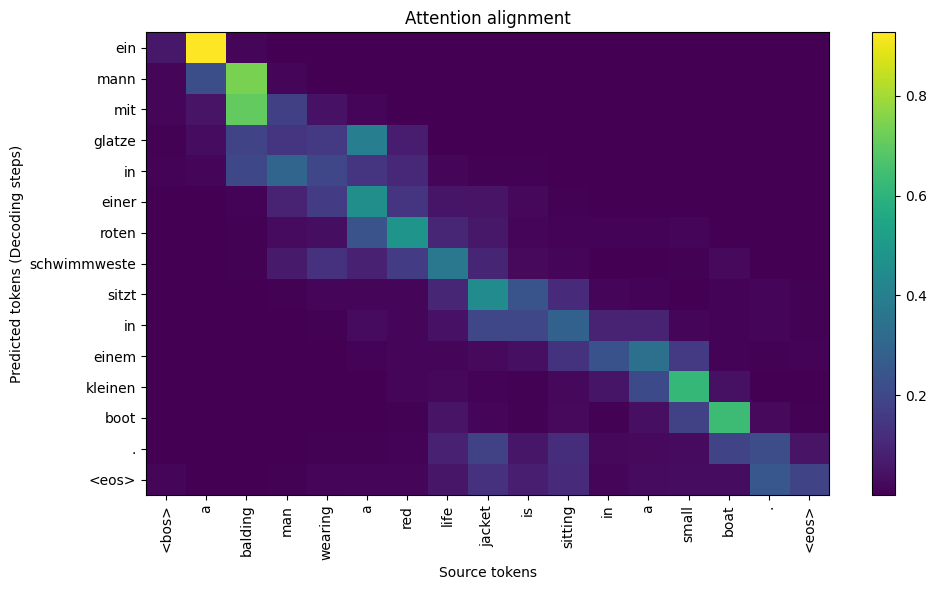

SRC : a balding man wearing a red life jacket is sitting in a small boat .
PRED: ein mann mit glatze in einer roten schwimmweste sitzt in einem kleinen boot .
REF : ein mann mit beginnender glatze , der eine rote rettungsweste trägt , sitzt in einem kleinen boot .


In [ ]:
# Draw a mini-batch from the validation set, decode with the best model,
# and inspect a few examples qualitatively:
#   - Plot attention heatmaps for selected sentences.
#   - Print source, model prediction, and reference translation side by side.

src, src_len, tgt, tgt_len = next(iter(valid_loader))
hyps, attn_map = beam_search_decode(plotting_model, src.to(DEVICE), src_len.to(DEVICE), max_len=40)
#If you want to visualise more, just change the x in range(x)
for i in range(5):
    plot_attention_heatmap(attn_map, src, hyps, idx=i)

    print("SRC :", ids_to_text(src[i].tolist()[1:], src_itos))
    print("PRED:", ids_to_text(hyps[i], tgt_itos))
    print("REF :", ids_to_text(tgt[i].tolist()[1:], tgt_itos))

## 5) Attention Entropy & Sharpness

> Blok alıntı ekle



- Per-step entropy: \( H = -\sum_i a_i \log a_i \)
- Sentence-level entropy: average across decoding steps
- Correlate with sentence-level BLEU (negative correlation ⇒ sharper attention ↔ better BLEU)


In [ ]:
# Analyze how sharp or diffuse the attention distribution is and how it relates to quality.
#   - attention_entropy: compute token-level entropy of attention weights.
#   - analyze_entropy_vs_bleu: for many sentences, collect average attention entropy
#     and corresponding sentence-level BLEU, then compute their correlation.
#   - scatter_entropy_bleu: scatter plot of entropy vs BLEU to visualize the relationship.

def attention_entropy(a: torch.Tensor, eps=1e-12):
    # a: B x Tgen x Ts
    p = a.clamp_min(eps)
    H = -(p * p.log()).sum(dim=-1)  # B x Tgen
    return H

def analyze_entropy_vs_bleu(model, loader, n_batches=5, max_len=60, decode_kwargs=None):
    model.eval()
    ents, bleus = [], []
    preds, refs = [], []
    with torch.no_grad():
        for b_idx, (src, src_len, tgt, tgt_len) in enumerate(loader):
            src, src_len = src.to(DEVICE), src_len.to(DEVICE)
            hyps, attn = beam_search_decode(model, src, src_len, max_len=max_len, **(decode_kwargs or {}))
            for i in range(len(hyps)):
                pred = ids_to_text(hyps[i], tgt_itos)
                ref  = ids_to_text(tgt[i].cpu().tolist()[1:], tgt_itos)
                preds.append(pred); refs.append(ref)
            H = attention_entropy(attn)  # B x Tgen
            H_sent = H.mean(dim=1).cpu().numpy().tolist()
            ents.extend(H_sent)
            if (b_idx+1) >= n_batches:
                break
    for p, r in zip(preds, refs):
        b = sacrebleu.sentence_bleu(p, [r]).score
        bleus.append(b)
    import numpy as np
    ents = np.array(ents); bleus = np.array(bleus)
    corr = np.corrcoef(ents, bleus)[0,1] if len(ents) > 1 else float("nan")
    print(f"Correlation (attention entropy vs sentence BLEU): {corr:.3f}  (neg ≈ sharper attention better)")
    return ents, bleus, corr

def scatter_entropy_bleu(ents, bleus):
    plt.figure(figsize=(6,4))
    plt.scatter(ents, bleus, s=12)
    plt.xlabel("Avg attention entropy (lower = sharper)")
    plt.ylabel("Sentence BLEU")
    plt.title("Entropy vs BLEU")
    plt.tight_layout()
    plt.show()

Correlation (attention entropy vs sentence BLEU): -0.152  (neg ≈ sharper attention better)


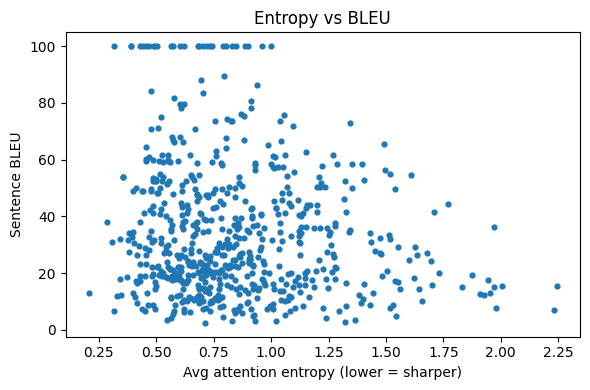

In [ ]:
# Run the entropy vs BLEU correlation experiment using the scaled-dot model
# and visualize the resulting scatter plot.

ents, bleus, corr = analyze_entropy_vs_bleu(plotting_model, valid_loader, n_batches=10)
scatter_entropy_bleu(ents, bleus)